     pcost       dcost       gap    pres   dres
 0:  1.2279e+03 -1.3111e+04  1e+04  3e-14  9e-15
 1:  1.1798e+02 -1.5089e+03  2e+03  2e-14  8e-15
 2: -2.2267e+02 -4.9527e+02  3e+02  7e-15  4e-15
 3: -2.9686e+02 -4.0621e+02  1e+02  1e-14  5e-15
 4: -3.0744e+02 -3.7129e+02  6e+01  1e-14  6e-15
 5: -3.3295e+02 -3.4899e+02  2e+01  2e-16  7e-15
 6: -3.4016e+02 -3.4210e+02  2e+00  2e-16  1e-14
 7: -3.4089e+02 -3.4091e+02  2e-02  2e-16  1e-14
 8: -3.4090e+02 -3.4090e+02  2e-04  1e-14  1e-14
 9: -3.4090e+02 -3.4090e+02  2e-06  1e-14  9e-15
10: -3.4090e+02 -3.4090e+02  2e-08  3e-14  7e-15
Optimal solution found.


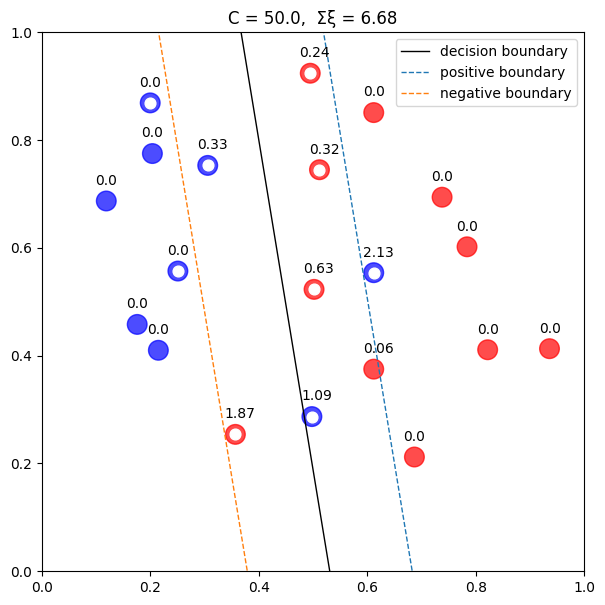

In [3]:
import numpy as np
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
import matplotlib.pyplot as plt

# Training data
x = np.array([[0.2,   0.869],
              [0.687, 0.212],
              [0.822, 0.411],
              [0.738, 0.694],
              [0.176, 0.458],
              [0.306, 0.753],
              [0.936, 0.413],
              [0.215, 0.410],
              [0.612, 0.375],
              [0.784, 0.602],
              [0.612, 0.554],
              [0.357, 0.254],
              [0.204, 0.775],
              [0.512, 0.745],
              [0.498, 0.287],
              [0.251, 0.557],
              [0.502, 0.523],
              [0.119, 0.687],
              [0.495, 0.924],
              [0.612, 0.851]])

y = np.array([-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1])
y = y.astype('float').reshape(-1, 1)

# ---- Calculate lambda using cvxopt ----

C = 50.0  # Soft margin parameter
N = x.shape[0]

# Calculate H matrix
H = np.dot(y, y.T) * np.dot(x, x.T)

# Construct the matrices required for QP in standard form
P = cvxopt_matrix(H)
q = cvxopt_matrix(np.ones(N) * -1)
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

# Inequality constraints (G, h)
g = np.vstack([-np.eye(N), np.eye(N)])
G = cvxopt_matrix(g)

h1 = np.hstack([np.zeros(N), np.ones(N) * C])
h = cvxopt_matrix(h1)

# Solver parameters
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

# Perform QP
sol = cvxopt_solvers.qp(P, q, G, h, A, b)

# The solution to the QP, λ
lamb = np.array(sol['x'])

# ---------------------------------------------------------------

# Calculate w using the lambda, which is the solution to QP
w = np.sum(lamb * y * x, axis=0)

# Find support vectors
sv_idx = np.where(lamb > 1e-5)[0]
sv_lamb = lamb[sv_idx]
sv_x = x[sv_idx]
sv_y = y[sv_idx]

sv_plus = sv_x[np.where(sv_y > 0)[0]]   # '+1' samples
sv_minus = sv_x[np.where(sv_y < 0)[0]]  # '-1' samples

# Calculate b using the support vectors and calculate the average
b = sv_y[0] - np.dot(w, sv_x[0])
b = np.mean(sv_y - np.dot(sv_x, w))

# With w and b, we can determine the Separating Hyperplane

# Visualize the data points
plt.figure(figsize=(7, 7))
color = ['red' if a == 1 else 'blue' for a in y]
plt.scatter(x[:, 0], x[:, 1], s=200, c=color, alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)

# Visualize the decision boundary
x1_dec = np.linspace(0, 1, 100)
x2_dec = -(w[0] * x1_dec + b) / w[1]
plt.plot(x1_dec, x2_dec, c='black', lw=1.0, label='decision boundary')

# Display slack variables, slack variable = max(0, 1 - y(wx + b))
y_hat = np.dot(x, w) + b
slack = np.maximum(0, 1 - y.flatten() * y_hat.flatten())
for s, (x1, x2) in zip(slack, x):
    plt.annotate(str(s.round(2)), (x1 - 0.02, x2 + 0.03))

# Visualize the positive & negative boundary and support vectors
w_norm = np.linalg.norm(w)
w_unit = w / w_norm
half_margin = 1 / w_norm
upper = np.array([x1_dec, -(w[0] * x1_dec + b - 1) / w[1]])
lower = np.array([x1_dec, -(w[0] * x1_dec + b + 1) / w[1]])

plt.plot(upper[0], upper[1], '--', lw=1.0, label='positive boundary')
plt.plot(lower[0], lower[1], '--', lw=1.0, label='negative boundary')

# Highlight support vectors
plt.scatter(sv_x[:, 0], sv_x[:, 1], s=60, marker='o', c='white')

plt.legend()
plt.title('C = ' + str(C) + ',  Σξ = ' + str(np.sum(slack).round(2)))
plt.show()
